In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
adj = pd.read_csv("hdfc_icici_adjclose_clean.csv", index_col=0, parse_dates=True)


In [9]:
r_H = adj['HDFCBANK.NS'].pct_change()
r_I = adj['ICICIBANK.NS'].pct_change()


In [12]:
# print(r_H.tail(10))
# print(r_I.tail(10))

# PnL calculation:

In [16]:
# ratio and rolling z
lookback = 30

ratio = adj['HDFCBANK.NS'] / adj['ICICIBANK.NS']
mean = ratio.rolling(lookback).mean()
std = ratio.rolling(lookback).std()
z = (ratio - mean) / std

In [17]:
# print("ratio tail:")
# print(ratio.tail(5).round(6))
# print("\nmean tail:")
# print(mean.tail(5).round(6))
# print("\nstd tail:")
# print(std.tail(5).round(6))
# print("\nz-score tail:")
# print(z.tail(5).round(4))

In [19]:
# generating trade signals
entry_z = 2.0   # entry z-score = +-2
exit_z  = 0.5

long_sig  = z < -entry_z     # Buy HDFC / Sell ICICI
short_sig = z >  entry_z     # Sell HDFC / Buy ICICI
exit_sig  = abs(z) < exit_z  # Close positions near mean

In [21]:
signals = pd.DataFrame({
    'zscore': z,
    'long': long_sig,
    'short': short_sig,
    'exit': exit_sig
})

In [23]:
#print(signals.tail(10))

# take positon - entry/exit

In [26]:
# daily position series

pos = pd.Series(0, index=z.index, dtype=int)
current=0

for t in z.index:
    if long_sig.loc[t]:
        current = 1      #go long ratio (buy hdfc/ sell icici)
    elif short_sig.loc[t]:
        current = -1
    elif exit_sig.loc[t]:
        current = 0
    pos.loc[t] = current
    
    

In [27]:
# print("last 10 rows of z, pos:")
# print(pd.concat([z.tail(10).round(3), pos.tail(10)], axis=1).rename(columns={0:'pos'}))
# print("\nposition counts:", pos.value_counts().to_dict())

# daily strategy


In [30]:
r_H = adj['HDFCBANK.NS'].pct_change().fillna(0)     #fillna(0) :  for NaN returns 0;
r_I = adj['ICICIBANK.NS'].pct_change().fillna(0)

In [31]:
pair_ret = r_H - r_I   # 1 for profit, -1 for loss

# yesterday's posn
pos_yesterday = pos.shift(1).fillna(0)        # +1/-1/0

In [32]:
# strategy daily return(profit/loss) and equity
strat_ret = pos_yesterday * pair_ret

# cumulative return
equity = strat_ret.cumsum()

In [38]:
# simple annualized stats (252 trading days)
ann_ret = strat_ret.mean() * 252             # return              
ann_vol = strat_ret.std() * np.sqrt(252)       # volatility
sharpe = (ann_ret / ann_vol) if (ann_vol != 0) else np.nan        # sharpe ratio

In [40]:
print("last 8 days: pos_yesterday | z | strat_ret | equity")
print(pd.concat([pos_yesterday.tail(8), z.tail(8).round(3), strat_ret.tail(8).round(5), equity.tail(8).round(4)], axis=1))
print(f"\nAnnRet={ann_ret:.4f}, AnnVol={ann_vol:.4f}, Sharpe={sharpe:.2f}")


last 8 days: pos_yesterday | z | strat_ret | equity
              0      1        2       3
Date                                   
2025-09-22  0.0  0.074 -0.00000  0.7411
2025-09-23  0.0 -0.127 -0.00000  0.7411
2025-09-24  0.0  0.158  0.00000  0.7411
2025-09-25  0.0  0.621  0.00000  0.7411
2025-09-26  0.0  1.472  0.00000  0.7411
2025-09-29  0.0  2.856  0.00000  0.7411
2025-09-30 -1.0  2.671 -0.00081  0.7403
2025-10-01 -1.0  2.160  0.00282  0.7431

AnnRet=0.1082, AnnVol=0.1490, Sharpe=0.73


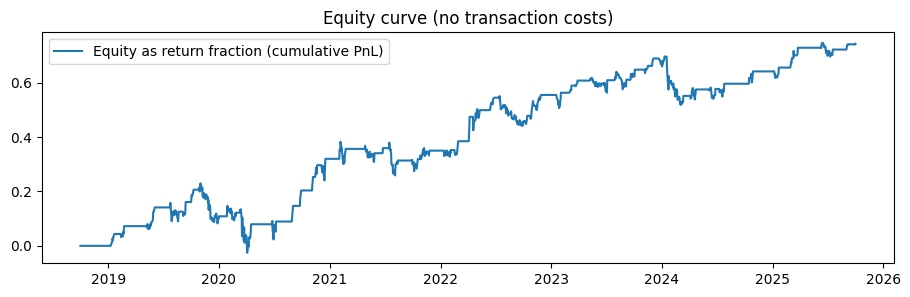

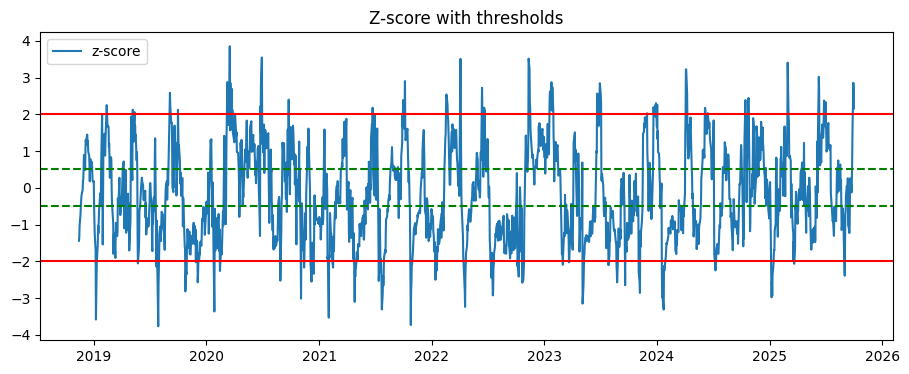

In [42]:
plt.figure(figsize=(11,3))
plt.plot(equity, label='Equity as return fraction (cumulative PnL)')
plt.title('Equity curve (no transaction costs)')
plt.legend(); plt.show()

plt.figure(figsize=(11,4))
plt.plot(z, label='z-score'); plt.axhline(2, color='r'); plt.axhline(-2, color='r')
plt.axhline(0.5, color='g', linestyle='--'); plt.axhline(-0.5, color='g', linestyle='--')
plt.legend(); plt.title('Z-score with thresholds'); plt.show()

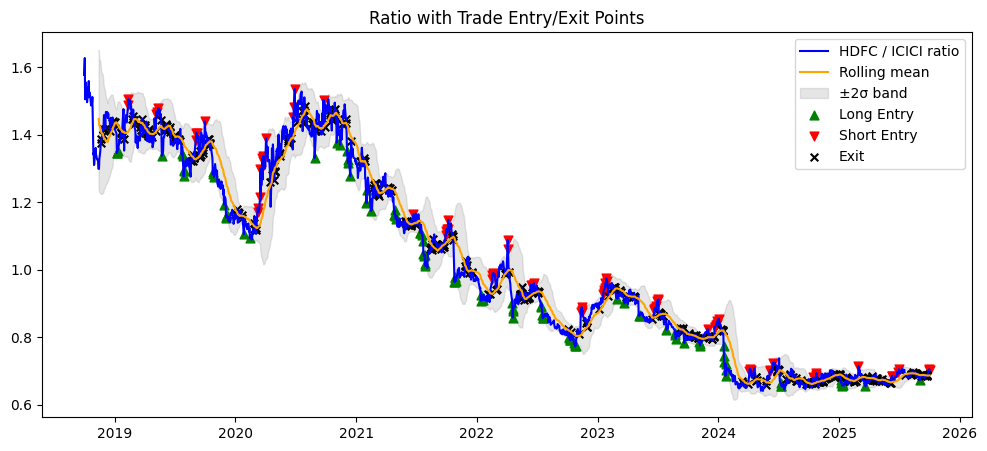

In [43]:
###################### Recheck ###################

# Mark entry/exit points
plt.figure(figsize=(12,5))
plt.plot(ratio, label='HDFC / ICICI ratio', color='blue')
plt.plot(mean, label='Rolling mean', color='orange')
plt.fill_between(ratio.index, (mean + 2*std), (mean - 2*std),
                 color='gray', alpha=0.2, label='±2σ band')


plt.scatter(ratio[long_sig].index, ratio[long_sig], marker='^', color='green', label='Long Entry', s=40)
plt.scatter(ratio[short_sig].index, ratio[short_sig], marker='v', color='red', label='Short Entry', s=40)
plt.scatter(ratio[exit_sig].index, ratio[exit_sig], marker='x', color='black', label='Exit', s=30)

plt.title('Ratio with Trade Entry/Exit Points')
plt.legend()
plt.show()


# realistic model - inclusion of transaction costs

In [49]:
# Brokerage + taxes	≈ 0.05 % (= 0.0005)
# Total (round trip) ≈ 0.1 % (= 0.001)

In [52]:
cost_per_trade = 0.001
trade_change = pos.diff().abs()    # change in position magnitude

cost = trade_change * cost_per_trade


In [54]:
strat_ret_net = strat_ret - cost
#print(strat_ret_net)

In [56]:
equity_net = strat_ret_net.cumsum()

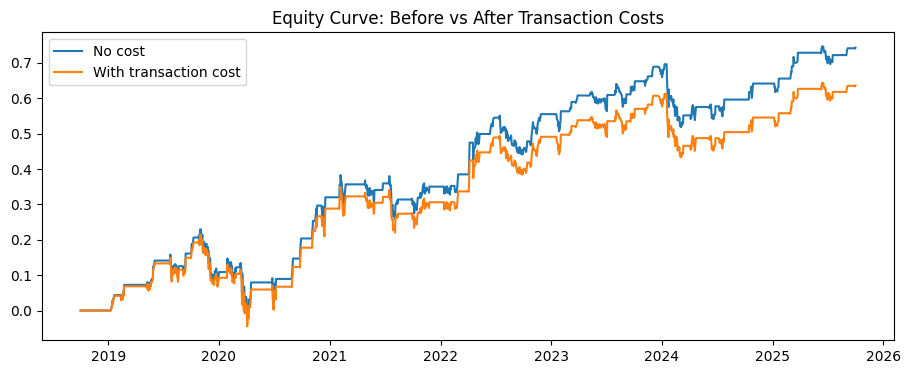

In [58]:
plt.figure(figsize=(11,4))
plt.plot(equity, label='No cost')
plt.plot(equity_net, label='With transaction cost')
plt.legend(); plt.title('Equity Curve: Before vs After Transaction Costs')
plt.show()

In [60]:

print(f"Total raw PnL: {equity.iloc[-1]:.4f}")
print(f"Total net PnL: {equity_net.iloc[-1]:.4f}")

Total raw PnL: 0.7431
Total net PnL: 0.6361


In [63]:
equity_net.to_csv("equity_net_series.csv", index=True)
pos.to_csv("pos_series.csv", index=True)
strat_ret.to_csv("strat_ret_series.csv", index=True)